   user_id          login_time               ip resource
0        1 2023-01-02 03:35:00     192.168.78.0    fileD
1        1 2023-01-02 08:10:00   192.168.54.244    fileA
2        1 2023-01-03 02:00:00   192.168.239.49    fileA
3        1 2023-01-01 21:35:00   192.168.109.38    fileC
4        1 2023-01-02 08:47:00  192.168.126.145    fileB
   user_id  avg_login_hour  std_login_hour  unique_ips  unique_resources
0        1       11.066667        7.172425          30                 4
1        2        8.966667        6.640956          30                 4
2        3       13.200000        6.025234          30                 4
3        4       13.000000        7.561244          30                 4
4        5       13.266667        5.824640          30                 4
    user_id  avg_login_hour  std_login_hour  unique_ips  unique_resources  \
0         1       11.066667        7.172425          30                 4   
1         2        8.966667        6.640956          30           

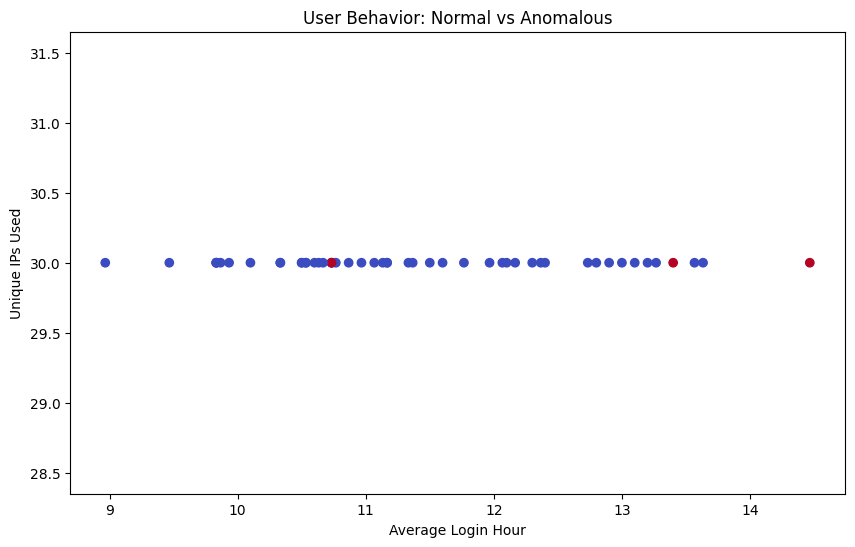

Results saved to user_behavior_anomalies.csv


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from datetime import datetime, timedelta
import random

num_users = 50
records_per_user = 30

data = []

for user_id in range(1, num_users + 1):
    base_time = datetime(2023, 1, 1, 9, 0, 0)  # Start time

    for i in range(records_per_user):
        login_offset = timedelta(minutes=random.randint(0, 60*24))
        login_time = base_time + login_offset
        ip = f"192.168.{random.randint(0, 255)}.{random.randint(0, 255)}"
        resource = random.choice(["fileA", "fileB", "fileC", "fileD"])
        
        # Introduce some anomalies
        if random.random() < 0.05:  # 5% chance to create anomaly
            login_time = base_time + timedelta(hours=random.randint(23, 48))
        
        data.append([user_id, login_time, ip, resource])

df = pd.DataFrame(data, columns=["user_id", "login_time", "ip", "resource"])

print(df.head())

df['login_hour'] = df['login_time'].dt.hour

user_features = df.groupby('user_id').agg({
    'login_hour': ['mean', 'std'],
    'ip': 'nunique',
    'resource': 'nunique'
}).reset_index()

user_features.columns = ['user_id', 'avg_login_hour', 'std_login_hour', 'unique_ips', 'unique_resources']

print(user_features.head())


X = user_features.drop('user_id', axis=1)

model = IsolationForest(contamination=0.05, random_state=42)
model.fit(X)

user_features['anomaly'] = model.predict(X)
user_features['anomaly'] = user_features['anomaly'].map({1: 0, -1: 1})  # 1 means anomaly

print(user_features)

plt.figure(figsize=(10, 6))
plt.scatter(user_features['avg_login_hour'], user_features['unique_ips'],
            c=user_features['anomaly'], cmap='coolwarm', marker='o')
plt.xlabel('Average Login Hour')
plt.ylabel('Unique IPs Used')
plt.title('User Behavior: Normal vs Anomalous')
plt.show()

user_features.to_csv("user_behavior_anomalies.csv", index=False)
print("Results saved to user_behavior_anomalies.csv")
